# Text Classification with NLP and Word2Vec

## Summary

This notebook shows how to perform  multiclass classification using Word Embedding (with Word2Vec) in Python

Adapted from https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils

In particular, we will go through:
* <a href='#1.-Setup'>Setup:</a>
  - <a href="#1.1-Import-packages">import packages</a>
  - <a href="#1.2.-Read-data">read data</a>
  - <a href="#1.3.-Preprocessing">Preprocessing</a>
    - <a href="#1.3.1-Train/Test-split">train/test split</a>
    - <a href="#1.3.2-Length-Analysis">Length analysis</a>
    - <a href="#1.3.3-Word-frequency">Word Frequency</a>
  - <a href="">Partitioning</a>
* <a href="#2.-Word-Embedding">Word Embedding: </a>
  - <a href="#2.1-Fitting-a-Word2Vec-model-with-gensim">Fitting a Word2Vec model with gensim</a>
  - <a href="#2.2-Feature-engineering">Feature Engineering</a>
  - <a href="#2.3.-Deep-Learning-with-tensorflow/keras">Deep Learning with tensorflow/keras</a>
  - <a href="#2.4-Testing-&-Evaluation">Testing & Evaluation</a>

## 1. Setup

### 1.1 Import packages

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
sys.path.append('..')

In [1]:
import re
import spacy
import emoji
import string
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from src.plot_utils import plot_categories

### 1.2. Read data

The dataset is downloaded from https://github.com/t-davidson/hate-speech-and-offensive-language as a csv file, which is then read into a pandas dataframe. This dataset contains 3 categories, `offensive_language`, `hate_speech` and `neither`.

In [2]:
df = pd.read_csv('data/t_davidson_hate_speech_and_offensive_language.csv', index_col=0)

In order to understand the composition of the dataset, we'll look into the univariate distribution of the target by showing labels frequency with a bar plot.

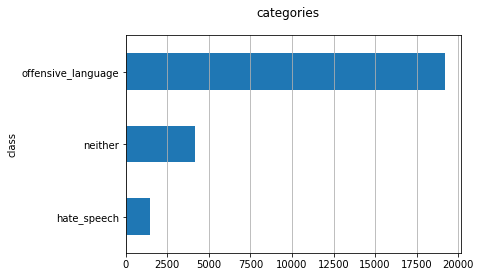

In [3]:
plot_categories(df)

The dataset is imbalanced: the proportion of `hate_speech` tweets is really small compared to the others, this will make for models to recognize `hate_speech` rather tough.

### 1.3. Preprocessing

Before explaining and building the models, I am going to give an example of preprocessing by cleaning text, removing stop words, and applying lemmatization. Using the `TextPreprocessor` class we can automatically clean the entire corpus. Below is a smaller example to highlight the main functionality of the text preprocessor.

In [4]:
from typing import List
from spacy.tokens import Doc

# load the existing spacy english word vocabulary
nlp = spacy.load('en_core_web_lg')

def utils_preprocess_text(text, custom_stopwords=['rt', 'amp', 'ai', 'nt', 'na', 'don'], debug_messages=False):
    """
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param custom_stopwords: list - list of stopwords to remove (additional to the already existing stopwords in spacy)
    :return
        cleaned text
    """
    
    def _remove_tweet_ats(s: str):
        return re.sub(r'@\S+', '', s)
    
    def _remove_links(s: str):
        return re.sub(r'https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)

    def _remove_numbers(s: str):
        return re.sub(r'\d*', '', s)

    def _remove_punct(s: str):
        return ''.join([c if c not in string.punctuation else ' ' for c in s])

    def _remove_stop_words(doc: Doc):
        return [t for t in doc if t.text.strip() and not t.is_stop]

    def _remove_emojis(s: str):
        return ''.join([c for c in s if c not in emoji.UNICODE_EMOJI['en']])

    def _remove_multiple_spaces(s: str):
        return re.sub(r'\s{2,}', ' ', s)

    def _lemmatize(doc: List):
        return ' '.join([t.lemma_ for t in doc])
    
    # add the custom stop words
    for stop_word in set(custom_stopwords):
        nlp.vocab[stop_word].is_stop = True
    
    text = text.lower()
    if debug_messages:
        print(f'input text{":":>14} {text}')
    text = _remove_tweet_ats(text)
    if debug_messages:
        print(f'removed ats{":":>13} {text}')
    text = _remove_links(text)
    if debug_messages:
        print(f'removed links{":":>11} {text}')
    text = _remove_emojis(text)
    if debug_messages:
        print(f'removed emojis{":":>10} {text}')
    text = _remove_numbers(text)
    if debug_messages:
        print(f'removed numbers{":":>9} {text}')
    text = _remove_punct(text)
    if debug_messages:
        print(f'removed punctuation{":":>5} {text}')
    text = _remove_multiple_spaces(text)
    if debug_messages:
        print(f'removed multiple spaces{":":>1} {text}')

    # tokenize the text
    doc = nlp(text)
    if debug_messages:
        msg = ' '.join(t.text for t in doc)
        print(f'tokenized text{":":>10}{msg}' )
        
    text = _remove_stop_words(doc)
    if debug_messages:
        msg = ' '.join(t.text for t in text)
        print(f'removed stop words{":":>6} {msg}')
        
    # back to string from list
    text = _lemmatize(text)
    if debug_messages:
        print(f'lemmatized text{":":>9} {text}')
        
    return text

We need to be very careful with stop words because if you remove the wrong token you may lose important information. For example, the word “will” was removed and we lost the information that the person is Will Smith. With this in mind, it can be useful to do some manual modification to the raw text before removing stop words (for example, replacing “Will Smith” with “Will_Smith”). Another solution here would be to use `spacy`'s Named Entity Recognition (NER) algorithm to identify persons, locations, events, etc. and replace the spaces in these identified features with underscores.

Now that we have all the useful tokens, we can apply word transformations. Stemming and Lemmatization both generate the root form of words. The difference is that stem might not be an actual word whereas lemma is an actual language word (although stemming is usually faster). We use the lemmatization algorithm available in `spacy`. Please note that you shouldn't apply both stemming and lemmatization.

As you can see, some words have changed: “cleaning” turned into its root form “clean”

In [5]:
utils_preprocess_text("!!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; Will Smith, you should always take the trash out... 😤", debug_messages=True)

input text             : !!!! rt @mayasolovely: as a woman you shouldn't complain about cleaning up your house. &amp; will smith, you should always take the trash out... 😤
removed ats            : !!!! rt  as a woman you shouldn't complain about cleaning up your house. &amp; will smith, you should always take the trash out... 😤
removed links          : !!!! rt  as a woman you shouldn't complain about cleaning up your house. &amp; will smith, you should always take the trash out... 😤
removed emojis         : !!!! rt  as a woman you shouldn't complain about cleaning up your house. &amp; will smith, you should always take the trash out... 
removed numbers        : !!!! rt  as a woman you shouldn't complain about cleaning up your house. &amp; will smith, you should always take the trash out... 
removed punctuation    :      rt  as a woman you shouldn t complain about cleaning up your house   amp  will smith  you should always take the trash out    
removed multiple spaces:  rt as a woman y

'woman shouldn t complain clean house smith trash'

All of these functions can be easily applied on an entire dataframe:

In [6]:
clean_text_df = df.copy()
clean_text_df['tweet_clean'] = clean_text_df['tweet'].map(utils_preprocess_text)
clean_text_df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_clean
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldn t complain clean house man trash
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold tyga dwn bad cuffin dat hoe st p...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg fuck bitch start cry confused shit
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear true faker bitch tell ya


### 1.3.1 Train/Test split

In [7]:
sentences = clean_text_df['tweet']
mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
y = clean_text_df[['class']]
y = y.replace({'class': mapping})['class']

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.1, random_state=1000)

### 1.3.2 Length Analysis

It’s important to have a look at the length of the text because it’s an easy calculation that can give a lot of insights. Maybe, for instance, we are lucky enough to discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model. Unfortunately, this won’t be the case as news headlines have similar lengths, but it’s worth a try.

There are several length measures for text data. Here are some examples:
* word count: counts the number of tokens in the text (separated by a space)
* character count: sum the number of characters of each token
* sentence count: count the number of sentences (separated by a period)
* average word length: sum of words length divided by the number of words (character count/word count)
* average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count)

In [8]:
dtf = df.copy()
dtf['word_count'] = dtf["tweet"].apply(lambda x: len(str(x).split(" ")))
dtf['char_count'] = dtf["tweet"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
dtf['sentence_count'] = dtf["tweet"].apply(lambda x: len(str(x).split(".")))
dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
dtf.head()

,count,hate_speech,offensive_language,neither,class,tweet,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,25,116,5,4.640000,5.0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,16,70,4,4.375000,4.0
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,21,100,1,4.761905,21.0
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,9,54,1,6.000000,9.0
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,26,112,1,4.307692,26.0


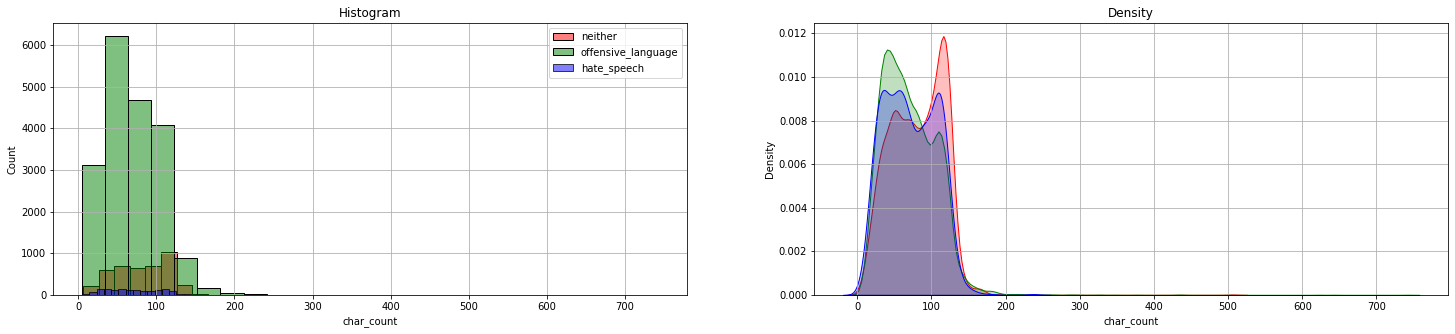

In [9]:
mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
dtf['class'] = dtf[['class']].replace({'class': mapping})['class']
colors = 'rgb'

x, y = "char_count", "class"
fig, ax = plt.subplots(1, 2, figsize=(25,5))

for idx, i in enumerate(reversed(list(mapping.values()))):
    d = dtf[dtf[y]==i][x]
    sns.histplot(data=d, bins=25, alpha=0.5, ax=ax[0], color=colors[idx])
    sns.kdeplot(data=d, shade=True, ax=ax[1], color=colors[idx])

ax[0].title.set_text('Histogram')
ax[0].grid(True)
ax[0].legend(dtf[y].unique())

ax[1].title.set_text('Density')
ax[1].grid(True)

The plots show that most of the tweets have a maximum length of around 200 characters, but have different distributions. This is a good indicator that the variables can be predicted individually since they have different patterns.

### 1.3.3 Word frequency

So far we’ve seen how to do feature engineering by analyzing and processing the whole text. Now we are going to look at the importance of single words by computing the n-grams frequency. An n-gram is a contiguous sequence of n items from a given sample of text. When the n-gram has the size of 1 is referred to as a unigram (size of 2 is a bigram).

For example, the phrase “I like this article” can be decomposed in:
- 4 unigrams: “I”, “like”, “this”, “article”
- 3 bigrams: “I like”, “like this”, “this article”

We will now calculate unigrams, bigrams and trigrams frequency of the `offensive_language` category.

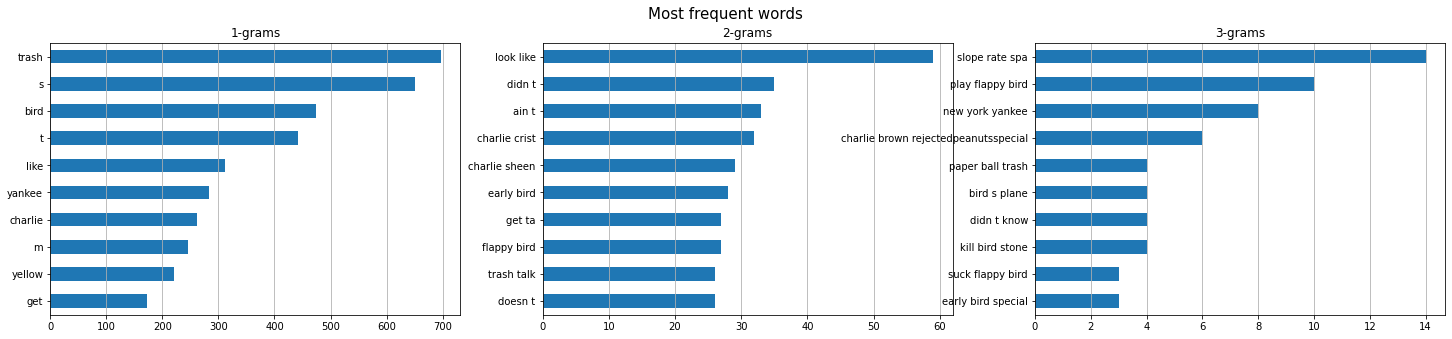

In [10]:
from collections import Counter
from gensim.models.phrases import Phrases, Phraser

corpus = clean_text_df[clean_text_df["class"]==2]["tweet_clean"]
unigrams = [doc.split(" ") for doc in corpus]

bigram = Phrases(unigrams, min_count=1, delimiter=b' ')
bigram_model = Phraser(bigram)

trigram = Phrases(bigram[unigrams], min_count=1, delimiter=b' ')
trigram_model = Phraser(trigram)

bigram_sentences = []
trigram_sentences = []
for s in unigrams:
    bigrams_list = bigram_model[s]
    bigrams_ = [b for b in bigrams_list if b.count(' ') == 1]
    bigram_sentences.extend(bigrams_)

    trigrams_list = trigram_model[bigram[s]]
    trigrams_ = [t for t in trigrams_list if t.count(' ') == 2]
    trigram_sentences.extend(trigrams_)

unigram_sentences = [item for sublist in unigrams for item in sublist]

unigram_dic_words_freq = Counter(unigram_sentences)
bigram_dic_words_freq = Counter(bigram_sentences)
trigram_dic_words_freq = Counter(trigram_sentences)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
fig.suptitle("Most frequent words", fontsize=15)

top = 10
for idx, grams_dict in enumerate([unigram_dic_words_freq, bigram_dic_words_freq, trigram_dic_words_freq]):
    dtf_uni = pd.DataFrame(grams_dict.most_common(top), columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title=f"{idx+1}-grams", ax=ax[idx], legend=False).grid(axis='x')
    ax[idx].set(ylabel=None)

## 2. Word Embedding

Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers. 
These vectors are calculated from the probability distribution for each word appearing before or after another. 
To put it another way, words of the same context usually appear together in the corpus, so they will be close in the vector space as well

Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space. That can be done using 2 different approaches: starting from a single word to predict its context (Skip-gram) or starting from the context to predict a word (Continuous Bag-of-Words).

### 2.1 Fitting a Word2Vec model with gensim

Instead of using a pre-trained model, We are going to fit our own Word2Vec on the training data corpus with gensim. 
Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams, as was already demonstrated.

When fitting the Word2Vec, we need to specify:
- the target size of the word vectors, I’ll use 300;
- the window, or the maximum distance between the current and predicted word within a sentence, I’ll use the mean length of text in the corpus;
- the training algorithm, I’ll use skip-grams (sg=1) as in general it has better results.

In [11]:
from gensim.models.word2vec import Word2Vec

nlp = Word2Vec(unigrams, size=300, window=8, min_count=1, sg=1, iter=30)

In [12]:
word = "trash"
nlp.wv[word].shape

(300,)

We can even use it to visualize a word and its context into a smaller dimensional space (2D or 3D) by applying any dimensionality reduction algorithm (i.e. TSNE).

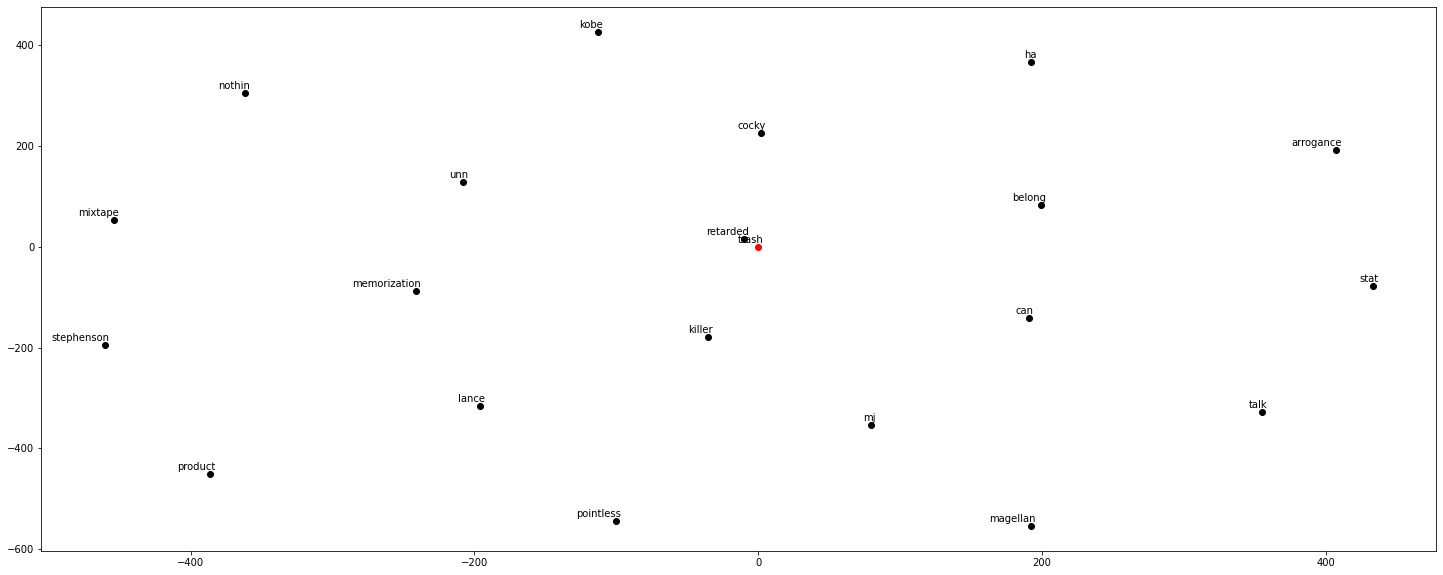

In [13]:
from sklearn import manifold

## find closest vectors
labels, X, x, y = [], [], [], []
for t in nlp.wv.most_similar(word, topn=20):
    X.append(nlp.wv[t[0]])
    labels.append(t[0])
    
## reduce dimensions
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
## plot
fig = plt.figure(figsize=(25,10))
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    
## add center
plt.scatter(x=0, y=0, c="red")
plt.annotate(word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

plt.show()

### 2.2 Feature engineering

How can the word embedding be useful to predict the selected category? Well, the word vectors can be used in a neural network as weights. This is how:
- First, transform the corpus into padded sequences of word ids to get a feature matrix.
- Then, create an embedding matrix so that the vector of the word with id N is located at the Nth row.
- Finally, build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector.

Let’s start with the Feature Engineering by transforming the same preprocessed corpus (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras:

In [14]:
import keras.preprocessing as kp

corpus = sentences_train

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigram_model[lst_corpus])
lst_corpus = list(trigram_model[lst_corpus])

## tokenize text
tokenizer = kp.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kp.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

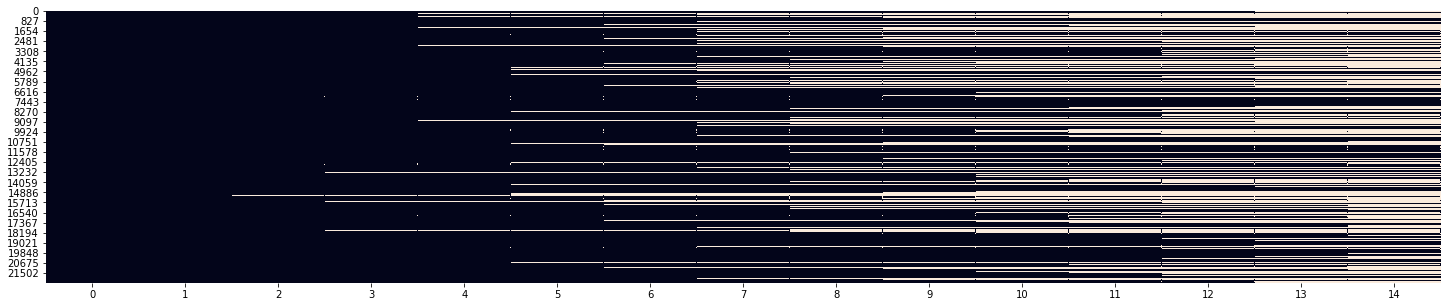

In [15]:
fig = plt.figure(figsize=(25,5))
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Every text in the corpus is now an id sequence with length 15. For instance, if a text had 10 tokens in it, then the sequence is composed of 10 ids + 5 0s, which is the padding element (while the id for word not in the vocabulary is 1). Let’s print how a text from the train set has been transformed into a sequence with the padding and the vocabulary.

In [16]:
i = 42

## list of text: ["I like this", ...]
len_txt = len(clean_text_df["tweet_clean"].iloc[i].split())
print("from: ", clean_text_df["tweet_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", clean_text_df["tweet_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[clean_text_df["tweet_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  nice girl bad naughty bad yello hoe real nice body south chick like em real thick | len: 16
to:  [ 292  418   36  161   16   11   24  166 3006    0    0    0    0    0
    0] | len: 15
check:  nice  -- idx in vocabulary --> 429
vocabulary:  {'NaN': 1, 'a': 2, 'rt': 3, 'i': 4, 'the': 5} ... (padding element, 0)


Before moving on, don’t forget to do the same feature engineering on the test set as well:

In [17]:
corpus = sentences_test

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigram_model[lst_corpus])
lst_corpus = list(trigram_model[lst_corpus])

## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kp.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

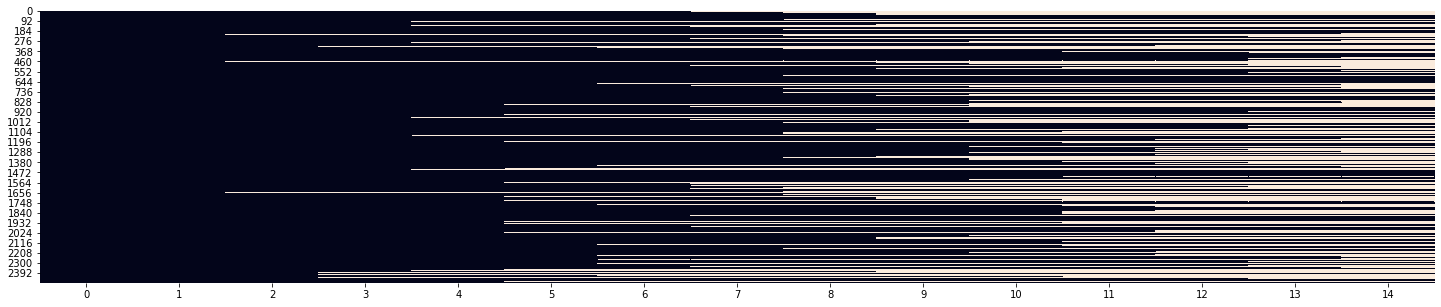

In [18]:
fig = plt.figure(figsize=(25,5))
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

We’ve got our X_train and X_test, now we need to create the matrix of embedding that will be used as a weight matrix in the neural network classifier.

In [19]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [20]:
embeddings.shape

(49896, 300)

This generates a matrix of shape n x 300 (Length of vocabulary extracted from the corpus x Vector size). It can be navigated by word id, which can be obtained from the vocabulary.

### 2.3. Deep Learning with tensorflow/keras

The neural network shall be structured as follows:

- an Embedding layer that takes the sequences as input and the word vectors as weights, just as described before.
- A simple Attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer (it isn't necessary for the predictions, just for the explainability, so you can skip it). The Attention mechanism was presented in this paper https://arxiv.org/abs/1409.0473 (2014) as a solution to the problem of the sequence models (i.e. LSTM) to understand what parts of a long text are actually relevant.
- Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.
- Two final dense layers that will predict the probability of each category.

In [21]:
from keras import layers, models

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      14968800    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

Now we can train the model and check the performance on a subset of the training set used for validation before testing it on the actual test set.

In [22]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=1, 
                     validation_split=0.3)

Epoch 1/10
61/61 [==============================] - 15s 161ms/step - loss: 0.9162 - accuracy: 0.7321 - val_loss: 0.6502 - val_accuracy: 0.7797
Epoch 2/10
61/61 [==============================] - 8s 129ms/step - loss: 0.6658 - accuracy: 0.7722 - val_loss: 0.6359 - val_accuracy: 0.7797
Epoch 3/10
61/61 [==============================] - 8s 130ms/step - loss: 0.6483 - accuracy: 0.7716 - val_loss: 0.5865 - val_accuracy: 0.8005
Epoch 4/10
61/61 [==============================] - 9s 149ms/step - loss: 0.5924 - accuracy: 0.8038 - val_loss: 0.5601 - val_accuracy: 0.8138
Epoch 5/10
61/61 [==============================] - 9s 147ms/step - loss: 0.5811 - accuracy: 0.8072 - val_loss: 0.5670 - val_accuracy: 0.8166
Epoch 6/10
61/61 [==============================] - 8s 139ms/step - loss: 0.5698 - accuracy: 0.8129 - val_loss: 0.5506 - val_accuracy: 0.8177
Epoch 7/10
61/61 [==============================] - 8s 136ms/step - loss: 0.5677 - accuracy: 0.8109 - val_loss: 0.5497 - val_accuracy: 0.8184
Epoch

### 2.4 Testing & Evaluation

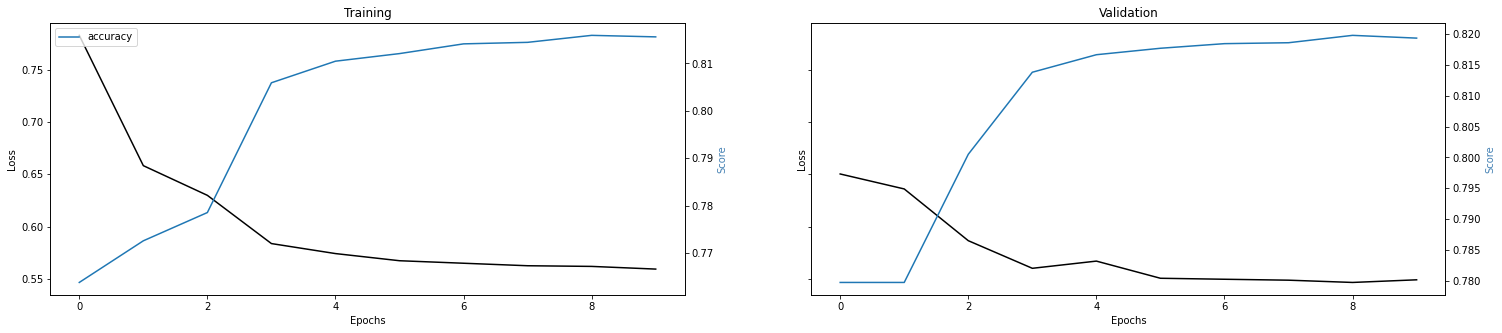

In [23]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 5))
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Accuracy: 0.81
Auc: 0.7
Detail:
                    precision    recall  f1-score   support

       hate_speech       0.00      0.00      0.00       131
           neither       0.78      0.31      0.44       438
offensive_language       0.81      0.98      0.89      1910

          accuracy                           0.81      2479
         macro avg       0.53      0.43      0.44      2479
      weighted avg       0.76      0.81      0.76      2479



c:\users\ng5ef3d\programs\miniconda3\envs\hate_speech\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ng5ef3d\programs\miniconda3\envs\hate_speech\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ng5ef3d\programs\miniconda3\envs\hate_speech\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

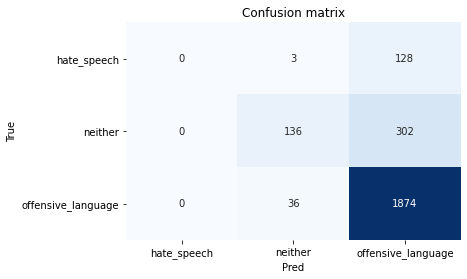

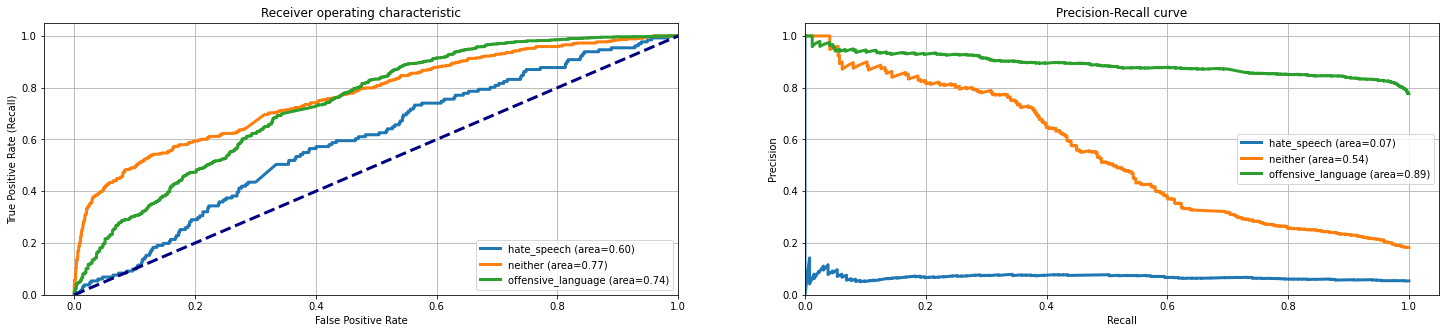

In [25]:
from src.eval_utils import evaluate_multi_classif

## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(25, 5))

Due to the limited data available for the `hate_speech` and `neither` classes, the model performs poorly. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning. The false-positive rate is also known as probability of false alarmand can be calculated as (1 − specificity). On the ROC-AUC graph, ideally the curves should tend towards the (0, 1) point:

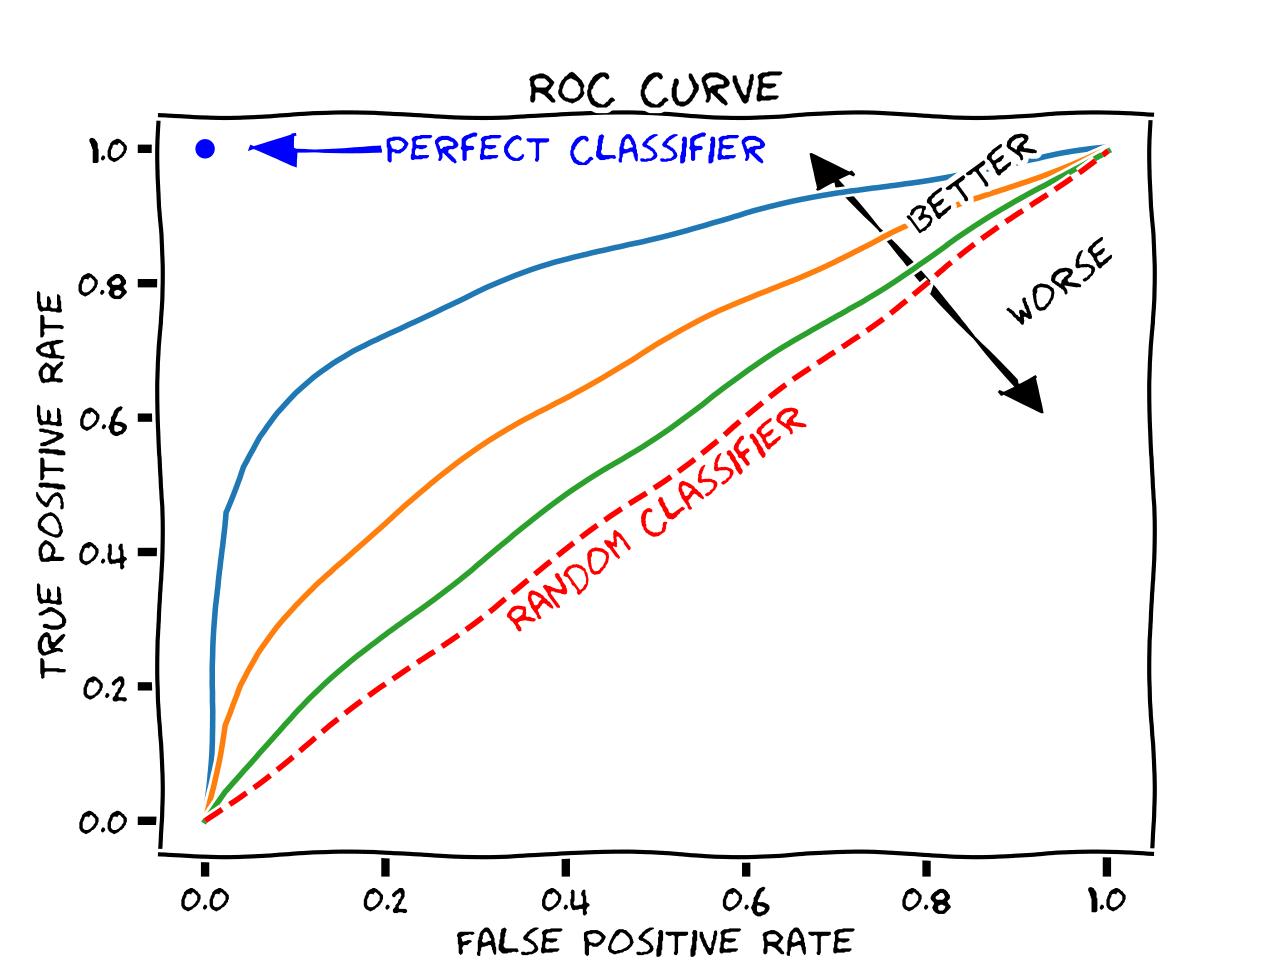

N.B.: the complete implementation has some extra optimizations which improve the accuracy of the model. Be sure to check out the other jupyter notebook